# limitations of SpenderQ

In [1]:
import os
import pickle
import numpy as np

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
niter = 3

# load model
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.rebin.iter%i.pt' % niter)

spec, weights, redshifts, norms, recon, true_cont = [], [], [], [], [], []
for ibatch in range(50): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
        _spec, w, z, _, norm, _ = pickle.load(f)
    spec.append(np.array(_spec))
    norms.append(np.array(norm))
    redshifts.append(np.array(z))
    weights.append(np.array(w))
    
    # load SpenderQ recon 
    recon.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.recons.npy' % (niter, ibatch)))
    # load true continuum
    true_cont.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch)))
    
spec = np.concatenate(spec, axis=0)
norms = np.concatenate(norms)
redshifts = np.concatenate(redshifts)
weights = np.concatenate(weights, axis=0)

recon = np.concatenate(recon, axis=0)
true_cont = np.concatenate(true_cont, axis=0)

w_recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i.wave_recon.npy' % niter)

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)

KeyboardI

In [ ]:
# continuum residual over full wavelength
wave_rest_rebin = np.linspace(800, 3000, 2000)

dcont_recon, dfcont_recon = [], []
bad_recon = []
for igal in range(len(redshifts)): 
    wlim = (wave_rest_rebin > 3.6e3/float(1+redshifts[igal])) & ((wave_rest_rebin < 9.9e3/float(1+redshifts[igal])))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + redshifts[igal]), 
        np.array(true_cont[igal]/norms[igal]), 
        xnew=wave_rest_rebin[wlim])
    
    # rebin reconstruction
    recon_rebin = U.trapz_rebin(
        w_recon, 
        recon[igal], 
        xnew=wave_rest_rebin[wlim])
    
    # residual
    dcont = np.repeat(-999., len(wave_rest_rebin))
    dcont[wlim] = true_rebin - recon_rebin 
    
    # fractional residual
    dfcont = np.repeat(-999., len(wave_rest_rebin))
    dfcont[wlim] = (true_rebin - recon_rebin)/true_rebin

    dcont_recon.append(dcont)
    dfcont_recon.append(dfcont)
    
    # check for bad recons
    wlim = (wave_rest_rebin > np.max([1040, 3.6e3/float(1+redshifts[igal])])) & (wave_rest_rebin < 1150)
    if np.median(dfcont[wlim]) > 0.25: 
        bad_recon.append(True)
    else: 
        bad_recon.append(False)
    
dcont_recon = np.array(dcont_recon)
dfcont_recon = np.array(dfcont_recon)

In [5]:
print(np.sum(bad_recon), np.mean(bad_recon))

357 0.00697265625


(2.1, 3.5)

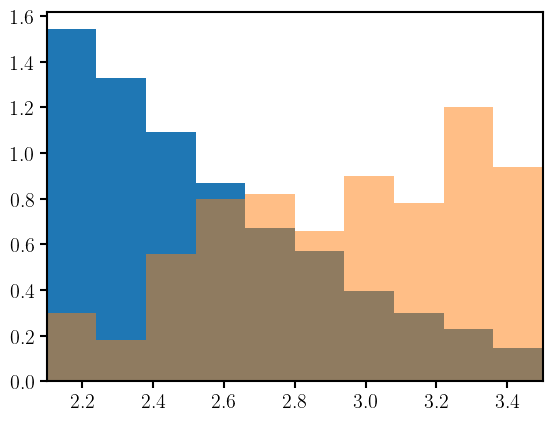

In [6]:
plt.hist(np.array(redshifts), range=(2.1, 3.5), bins=10, density=True)
plt.hist(np.array(redshifts)[bad_recon], range=(2.1, 3.5), bins=10, density=True, alpha=0.5)
plt.xlim(2.1, 3.5)

(-1.0, 1.5)

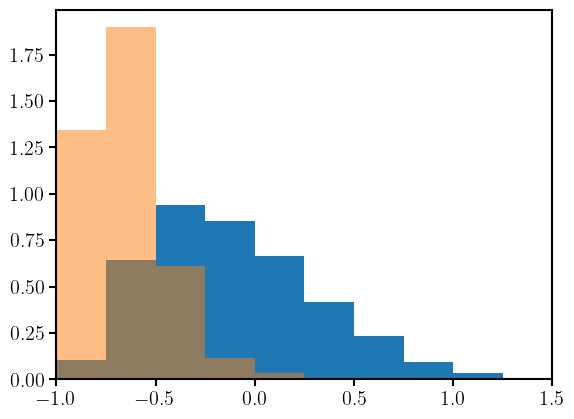

In [7]:
plt.hist(np.log10(np.array(norms)), range=(-1., 1.5), bins=10, density=True)
plt.hist(np.log10(np.array(norms))[bad_recon], range=(-1., 1.5), bins=10, density=True, alpha=0.5)
plt.xlim(-1., 1.5)

In [103]:
np.mean(median_snr[bad_recon] < 1)

np.float64(0.988795518207283)

In [101]:
np.quantile(median_snr[bad_recon], (0.99))

np.float32(0.9389936)

In [12]:
snr = weights**0.5 * spec 
median_snr = np.median(snr, axis=1) * norms

/tmp/ipykernel_2025151/1292258460.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(median_snr * norms), range=(-3, 3), density=True)
/tmp/ipykernel_2025151/1292258460.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(median_snr * norms)[bad_recon], range=(-3, 3), density=True, alpha=0.5)


(-3.0, 3.0)

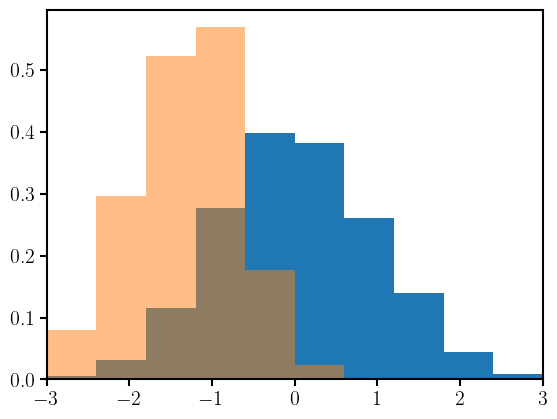

In [31]:
plt.hist(np.log10(median_snr), range=(-3, 3), density=True)
plt.hist(np.log10(median_snr)[bad_recon], range=(-3, 3), density=True, alpha=0.5)
plt.xlim(-3, 3)

In [35]:
wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]

/tmp/ipykernel_2025151/3448068347.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


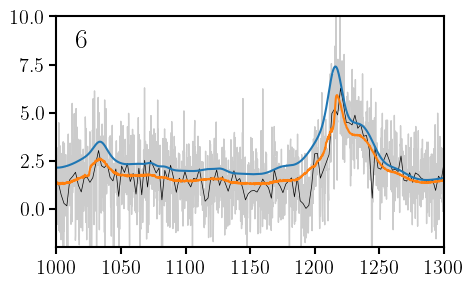

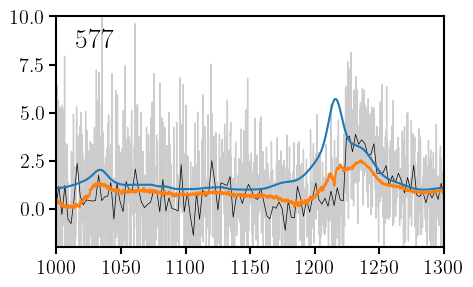

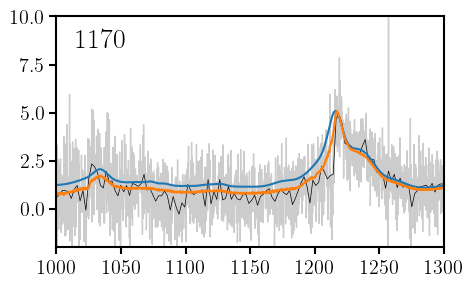

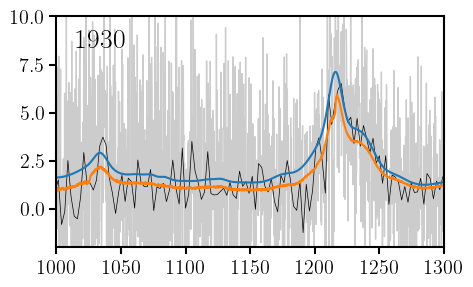

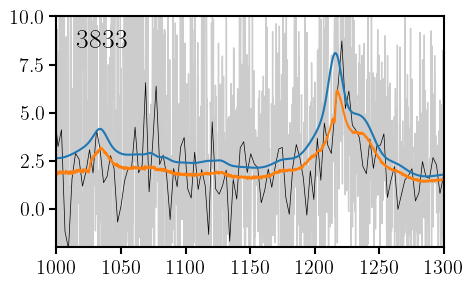

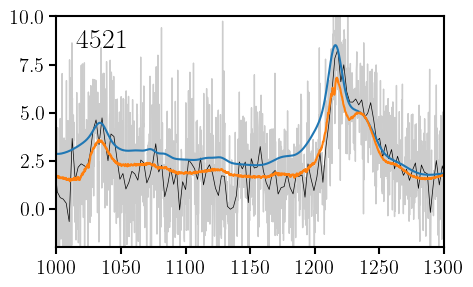

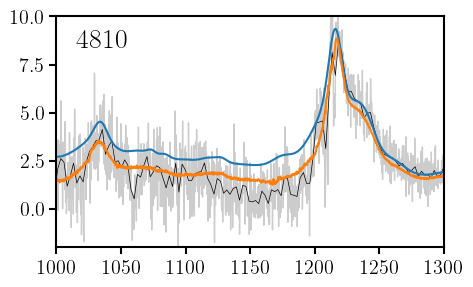

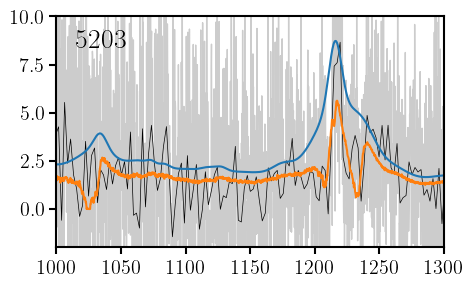

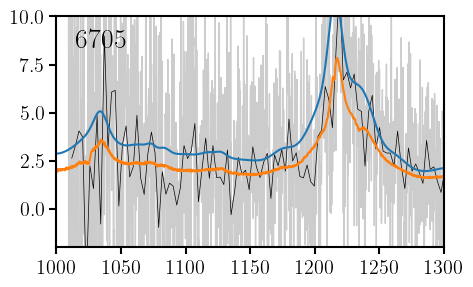

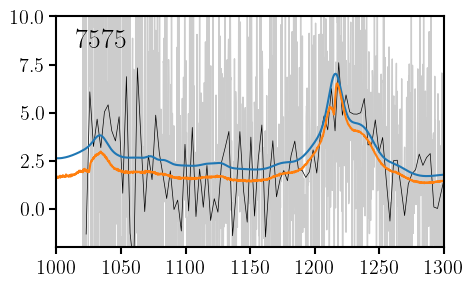

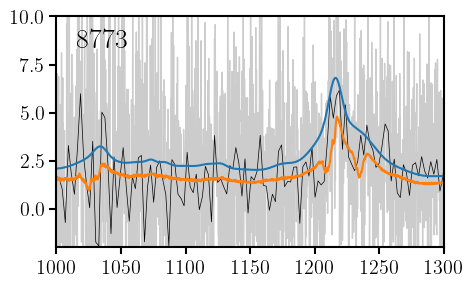

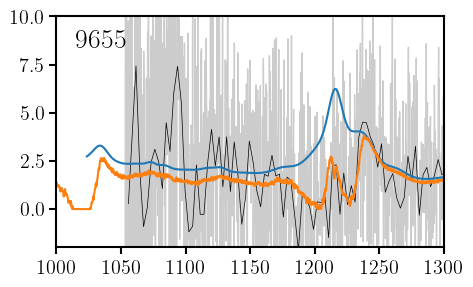

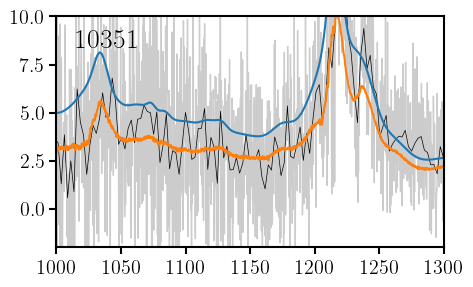

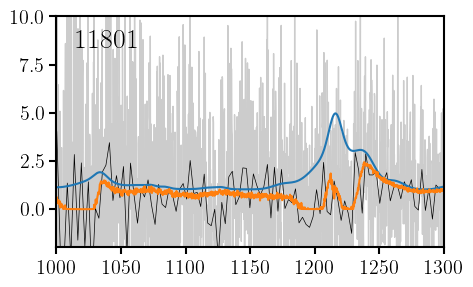

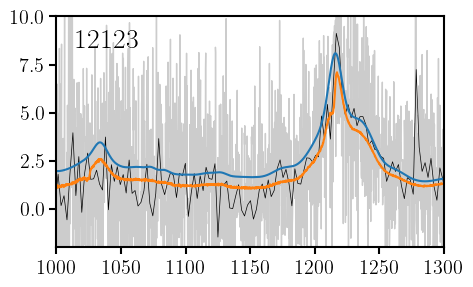

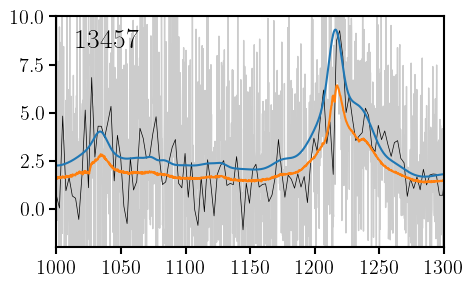

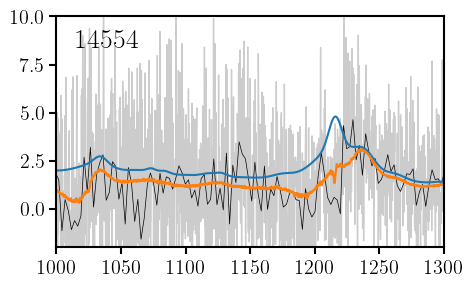

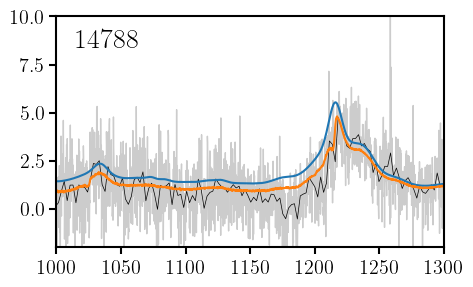

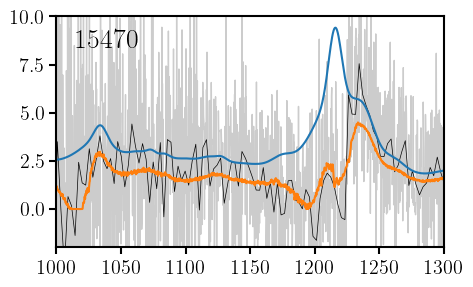

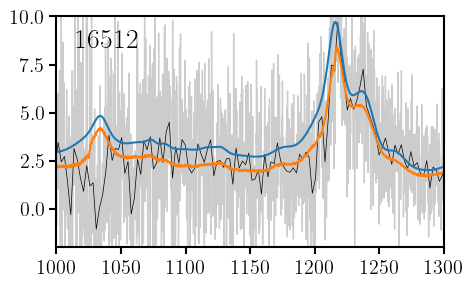

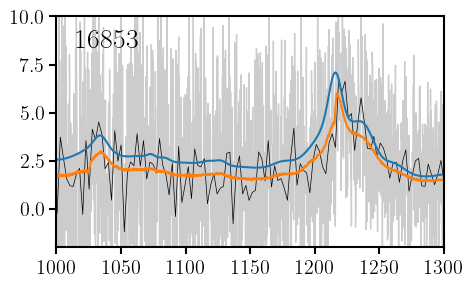

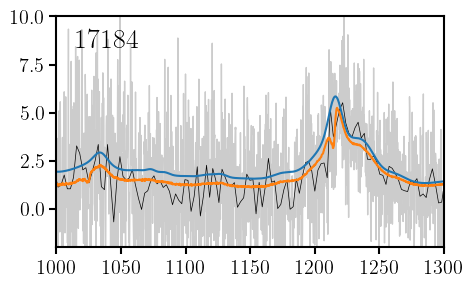

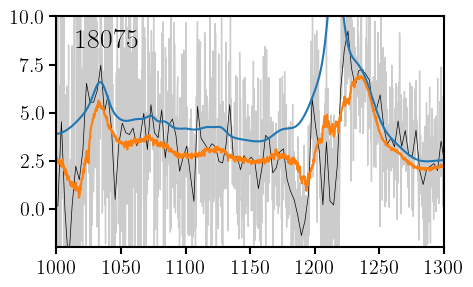

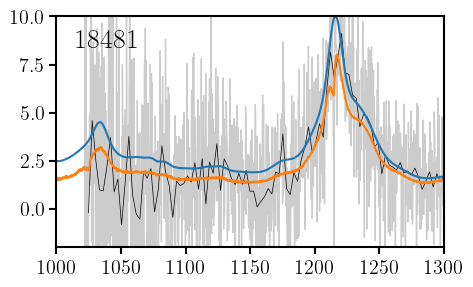

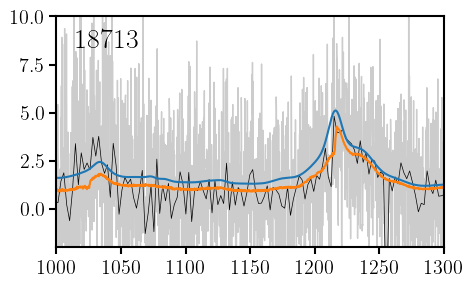

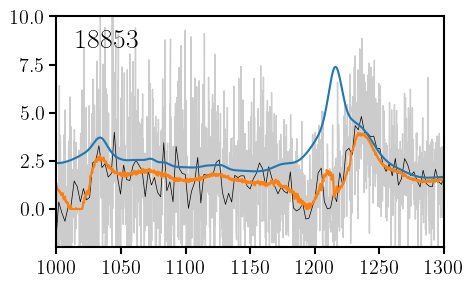

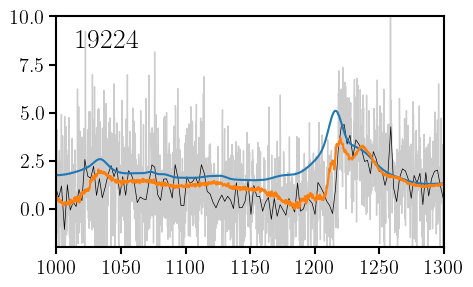

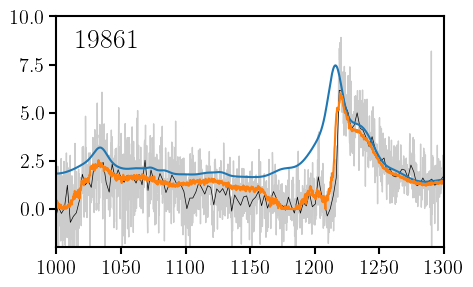

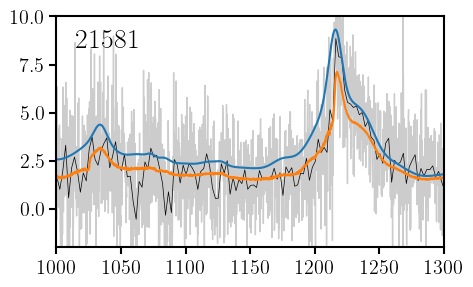

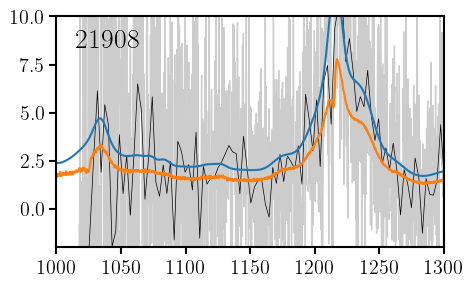

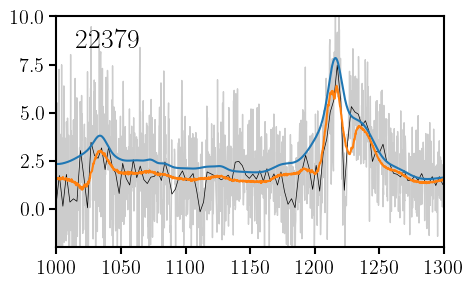

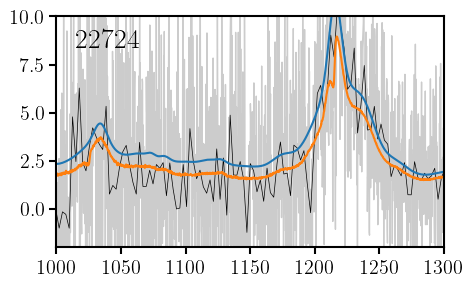

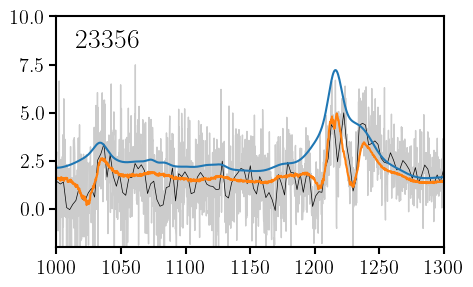

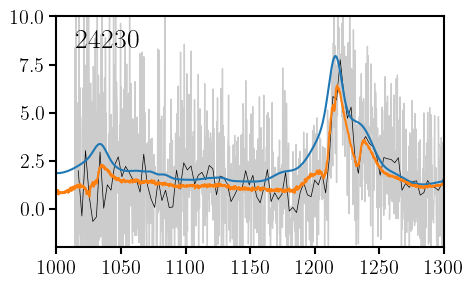

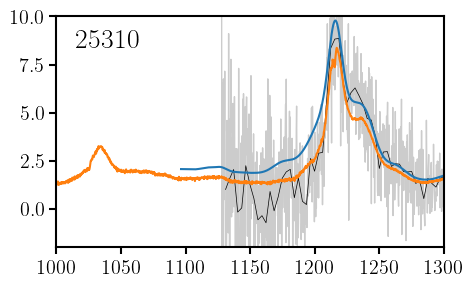

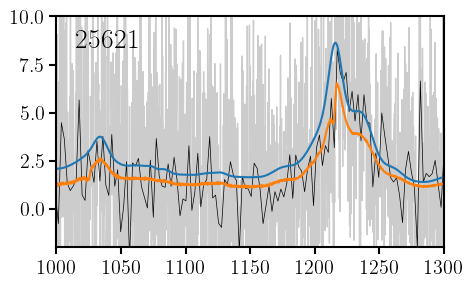

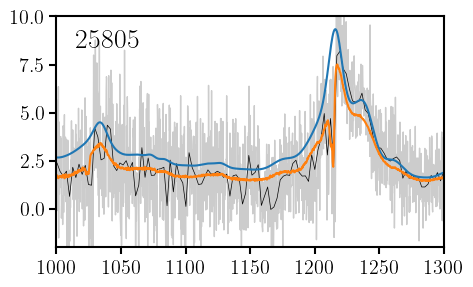

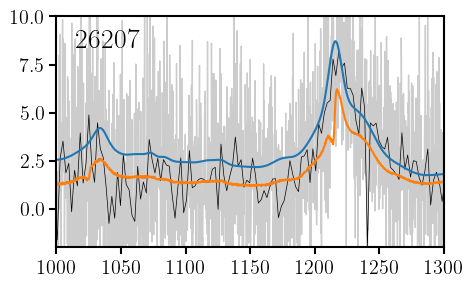

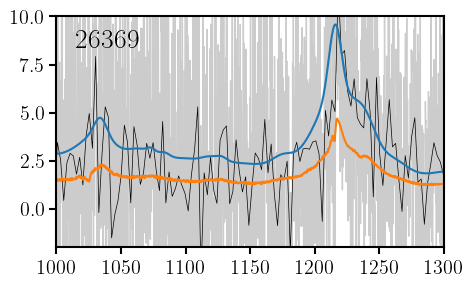

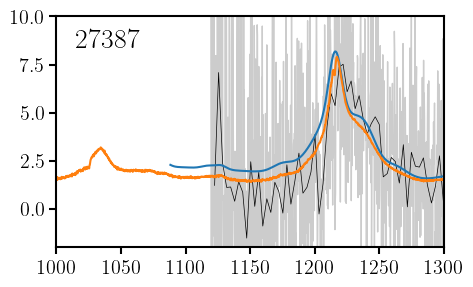

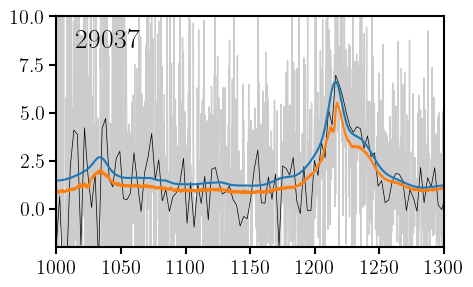

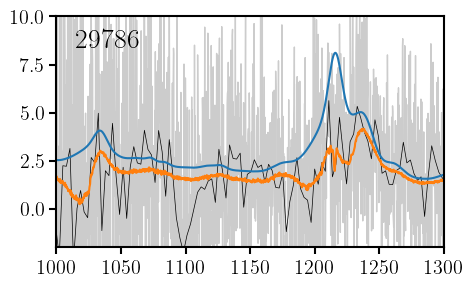

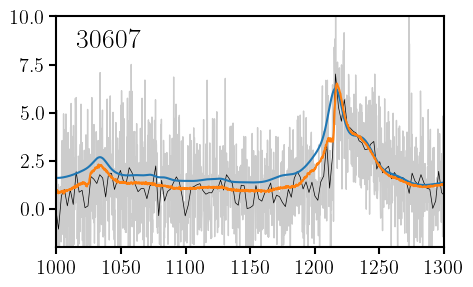

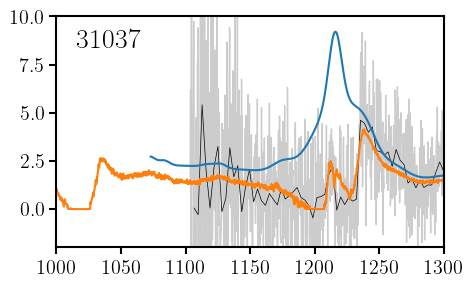

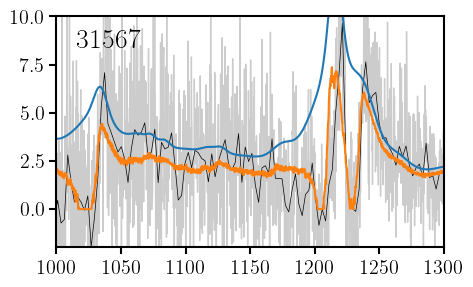

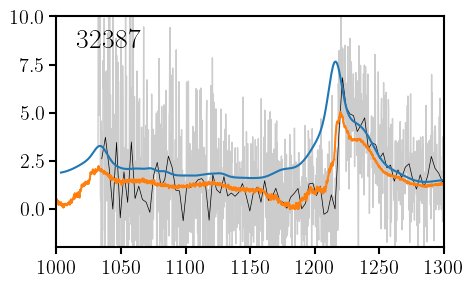

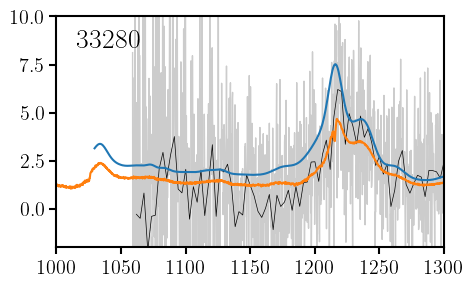

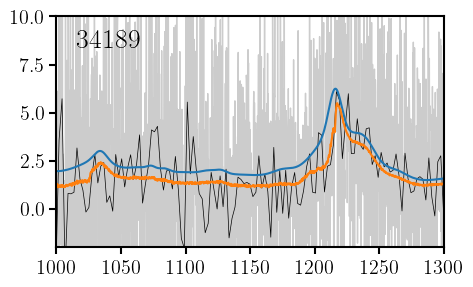

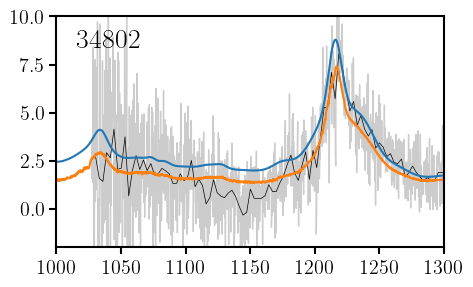

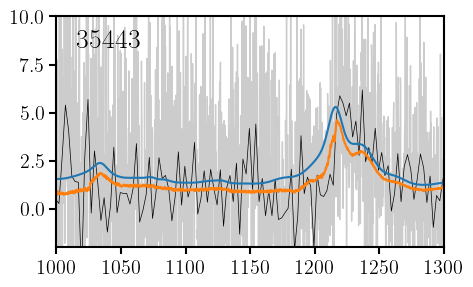

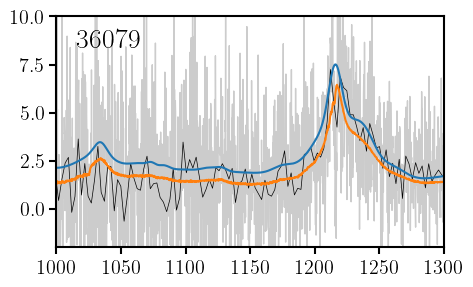

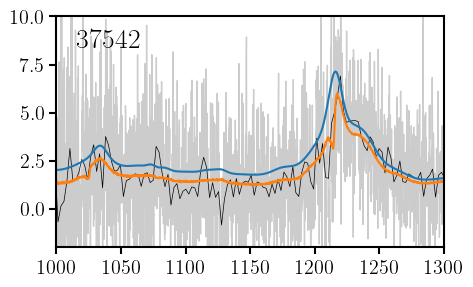

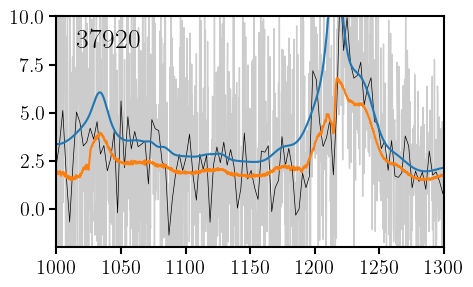

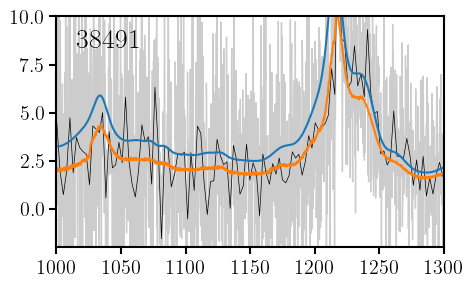

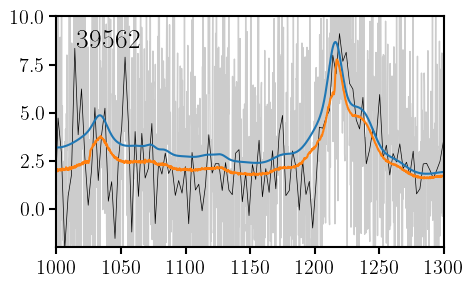

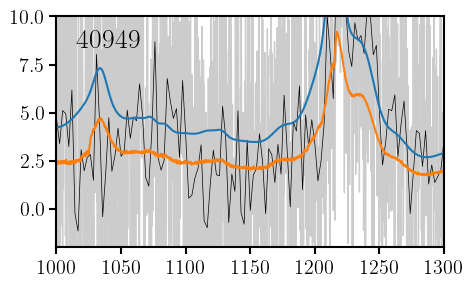

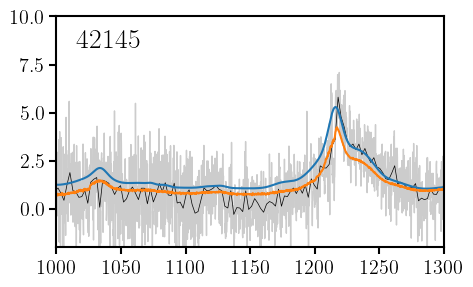

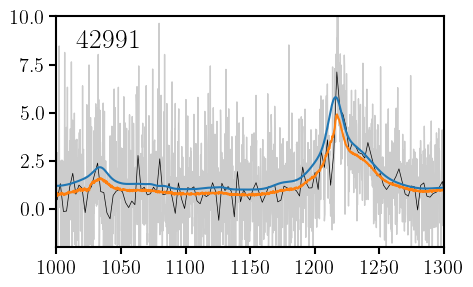

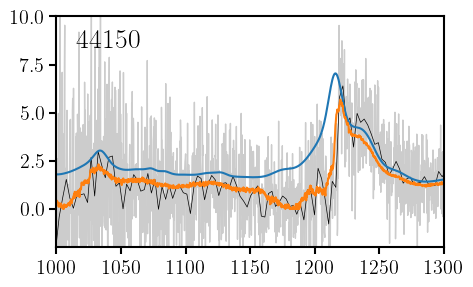

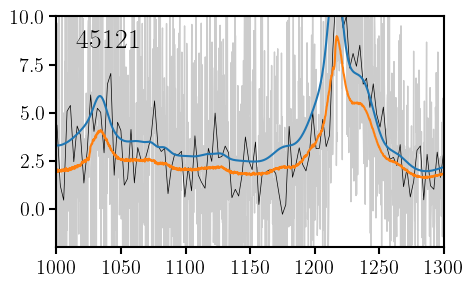

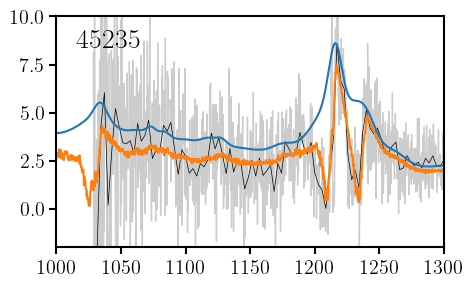

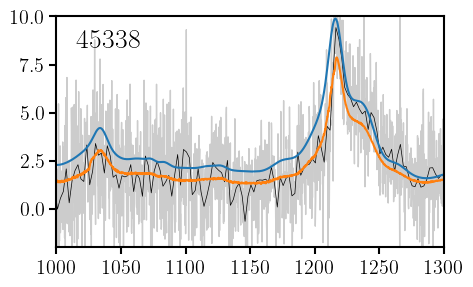

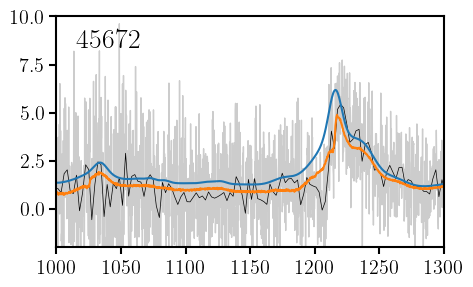

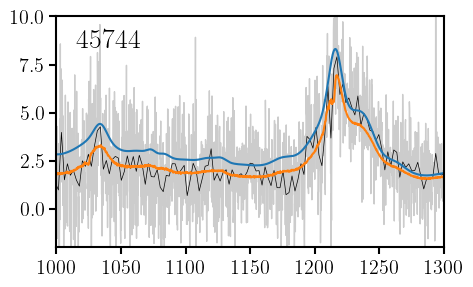

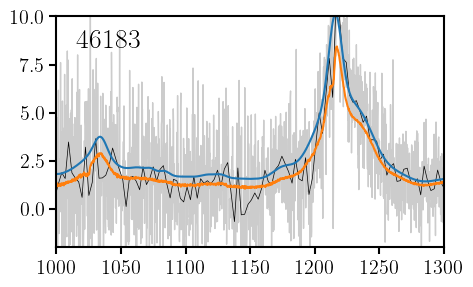

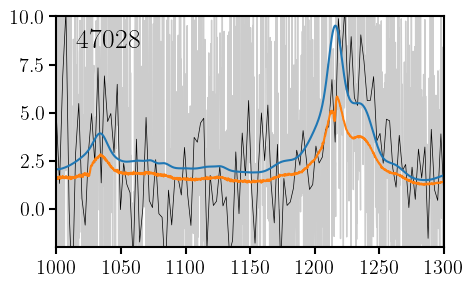

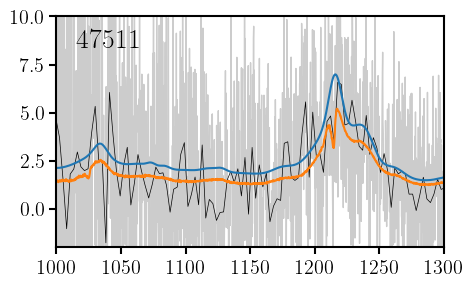

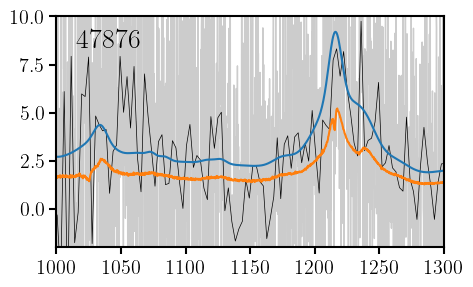

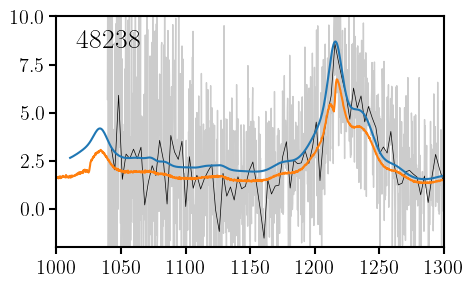

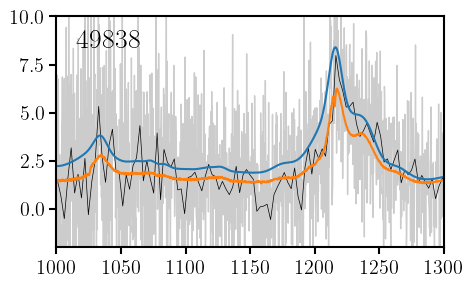

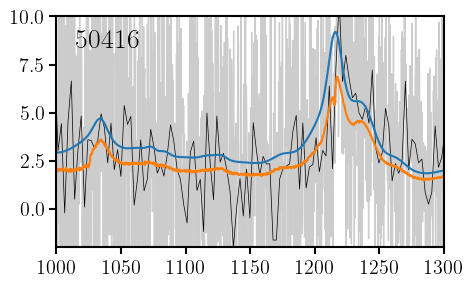

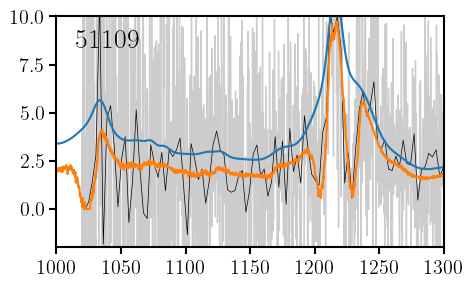

In [10]:
for igal in np.arange(len(redshifts))[bad_recon][::5]: 
    fig = plt.figure(figsize=(5,3))
    sub = fig.add_subplot(111)
    #wlim = (np.array(w[igal]) > 0)
    #sub.plot(models[0].wave_obs[wlim]/float(1+redshifts[igal]), spec[igal][wlim], c='k', lw=1, alpha=0.2)
    sub.plot(models[0].wave_obs/float(1+redshifts[igal]), spec[igal], c='k', lw=1, alpha=0.2)
    # coarse spectra
    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin/float(1+redshifts[igal]), spec_rebin, c='k', lw=0.5, label='(coarse binned)')
    
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/float(1+redshifts[igal]), np.array(true_cont[igal]/norms[igal]))
    sub.plot(w_recon, recon[igal])
    
    sub.text(0.05, 0.95, '%i' % igal, transform=sub.transAxes, ha='left', va='top', fontsize=20)
    sub.set_xlim(1e3, 1.3e3)
    sub.set_ylim(-2, 10)
    plt.show()

## with higher SNR

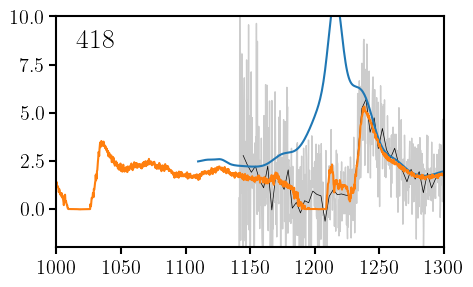

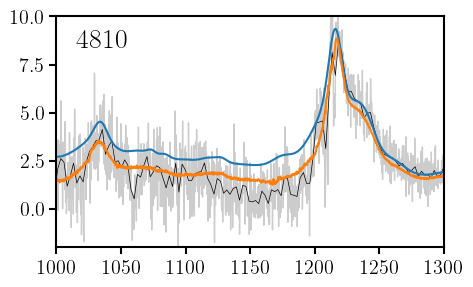

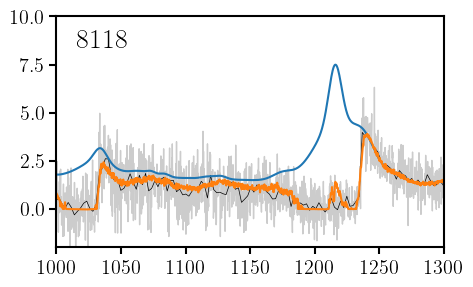

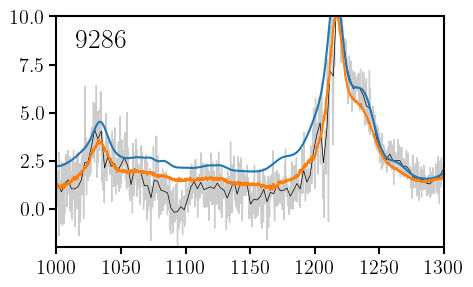

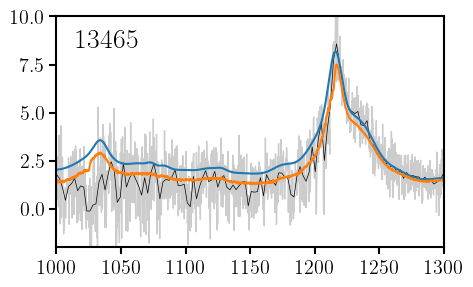

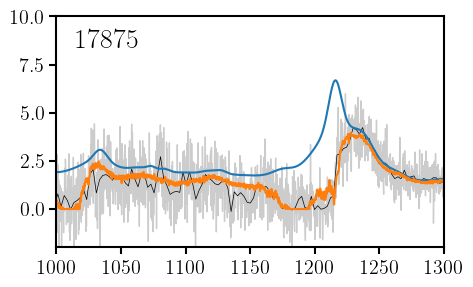

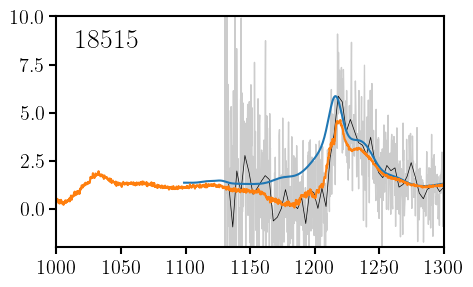

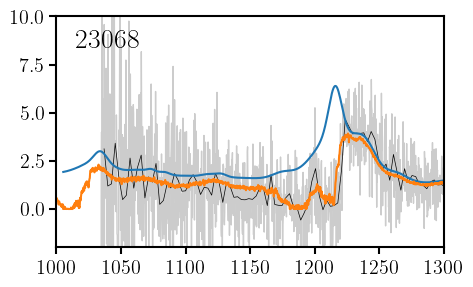

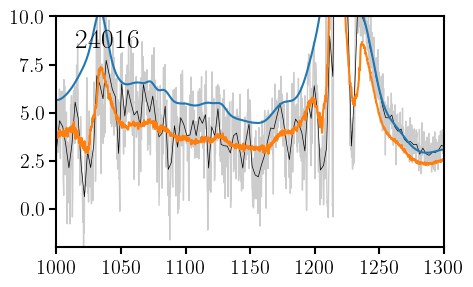

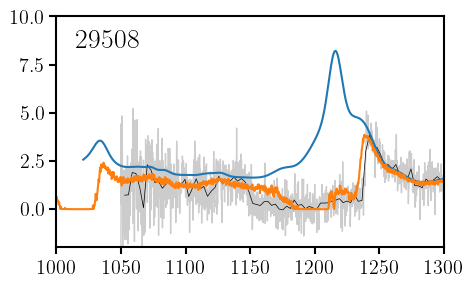

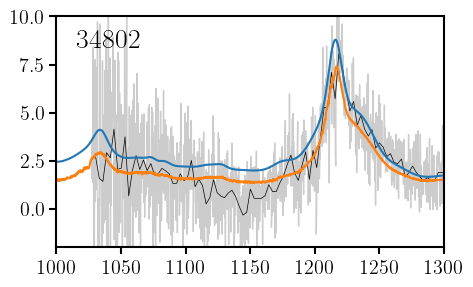

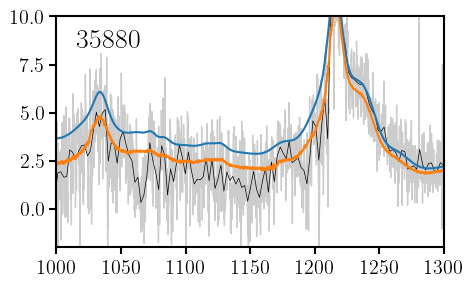

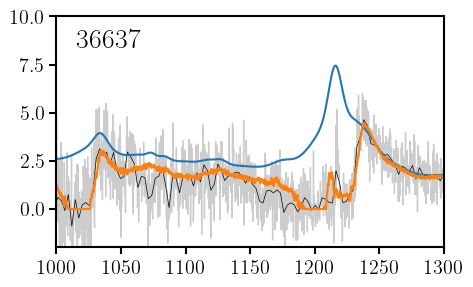

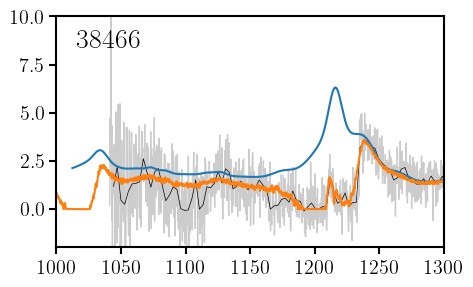

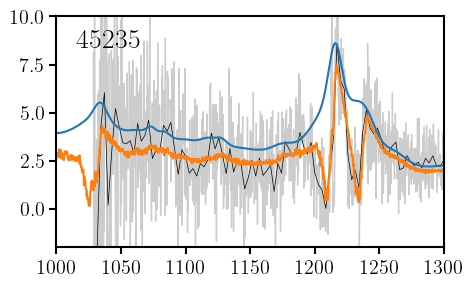

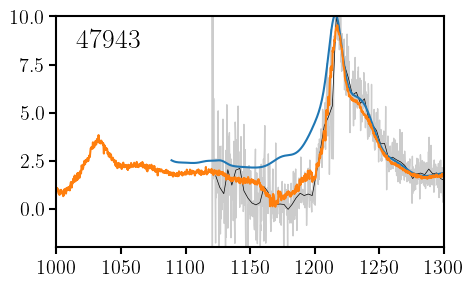

In [43]:
for igal in np.arange(len(redshifts))[bad_recon & (median_snr > 0.5)]: 
    fig = plt.figure(figsize=(5,3))
    sub = fig.add_subplot(111)
    #wlim = (np.array(w[igal]) > 0)
    #sub.plot(models[0].wave_obs[wlim]/float(1+redshifts[igal]), spec[igal][wlim], c='k', lw=1, alpha=0.2)
    sub.plot(models[0].wave_obs/float(1+redshifts[igal]), spec[igal], c='k', lw=1, alpha=0.2)
    # coarse spectra
    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin/float(1+redshifts[igal]), spec_rebin, c='k', lw=0.5, label='(coarse binned)')
    
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/float(1+redshifts[igal]), np.array(true_cont[igal]/norms[igal]))
    sub.plot(w_recon, recon[igal])
    
    sub.text(0.05, 0.95, '%i' % igal, transform=sub.transAxes, ha='left', va='top', fontsize=20)
    sub.set_xlim(1e3, 1.3e3)
    sub.set_ylim(-2, 10)
    plt.show()

9286
47943
8118
24016


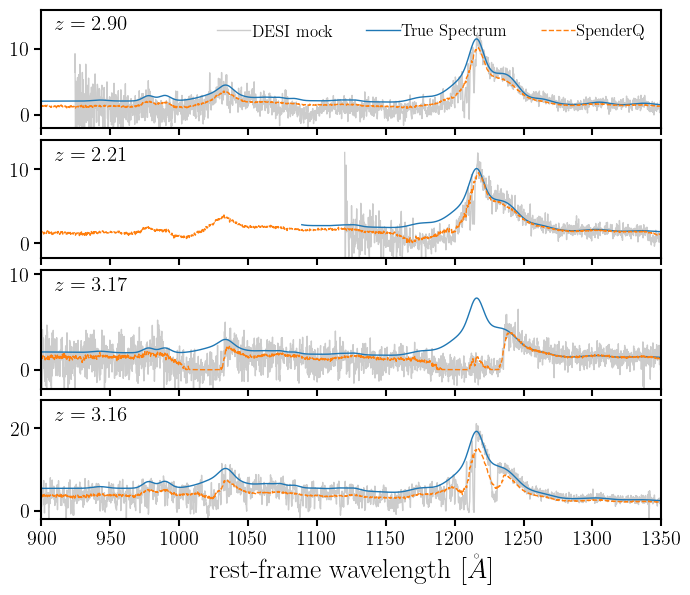

In [99]:
igals = np.random.choice(np.arange(len(redshifts))[bad_recon & (median_snr > 0.7)], 4, replace=False)

fig = plt.figure(figsize=(8,10))

for i, igal in enumerate(igals): 
    print(igal)
    sub = fig.add_subplot(6,1,i+1)
    #wlim = (np.array(w[igal]) > 0)
    #sub.plot(models[0].wave_obs[wlim]/float(1+redshifts[igal]), spec[igal][wlim], c='k', lw=1, alpha=0.2)
    sub.plot(models[0].wave_obs/float(1+redshifts[igal]), spec[igal], c='k', lw=1, alpha=0.2, label='DESI mock')
    # coarse spectra
    #spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    #sub.plot(wave_rebin/float(1+redshifts[igal]), spec_rebin, c='k', lw=0.5, label='(coarse binned)')
    
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/float(1+redshifts[igal]), np.array(true_cont[igal]/norms[igal]), 
            lw=1, label='True Spectrum')
    sub.plot(w_recon, recon[igal], lw=1, ls='--', label='SpenderQ')
    
    sub.text(0.02, 0.95, '$z=%.2f$' % redshifts[igal], transform=sub.transAxes, ha='left', va='top', fontsize=15)
    sub.set_xlim(900, 1.35e3)
    if i < len(igals)-1: sub.set_xticklabels([])
    else: sub.set_xlabel(r"rest-frame wavelength [$\AA$]", fontsize=20)

    if i == 0: sub.legend(loc='upper right', ncols=3, fontsize=12, handletextpad=0.1)
        
    #print(np.quantile(np.array(true_cont[igal]/norms[igal]), 0.99))
    sub.set_ylim(-2, 1.4*np.quantile(np.array(true_cont[igal]/norms[igal]), 0.999))
    
fig.subplots_adjust(hspace=0.1)
fig.savefig('bad_recon_highsnr.pdf', bbox_inches='tight')